In [11]:
import os
import numpy as np
from config import config
import pandas as pd
import librosa
import librosa.display
from IPython.display import Audio
import random
from scipy import fft
import noisereduce as nr
import soundfile
import time
from tqdm import tqdm
import pickle
import lzma
import matplotlib.pyplot as plt
from multiprocessing import Pool, freeze_support
import glob
import seaborn as sb

In [32]:
df_orig = pd.DataFrame()
df_orig['class'] = os.listdir('../datasets/birdclef22/train_audio/')
l = []
for folder in df_orig['class']:
    l.append(len(os.listdir(f'../datasets/birdclef22/train_audio/{folder}')))

df_orig['num'] = l

In [12]:
df = pd.DataFrame()
df['class'] = os.listdir('../datasets/numpy_mel/data/')
l = []
for folder in df['class']:
    l.append(len(os.listdir(f'../datasets/numpy_mel/data/{folder}')))

df['num'] = l

In [38]:
df_diff = pd.DataFrame()
df_diff['class'] = df_orig['class']
df_diff['diff'] = df['num'] - df_orig['num']

In [67]:
sb.set_style('whitegrid')
sb.set_theme("presentation")

ValueError: context must be in paper, notebook, talk, poster

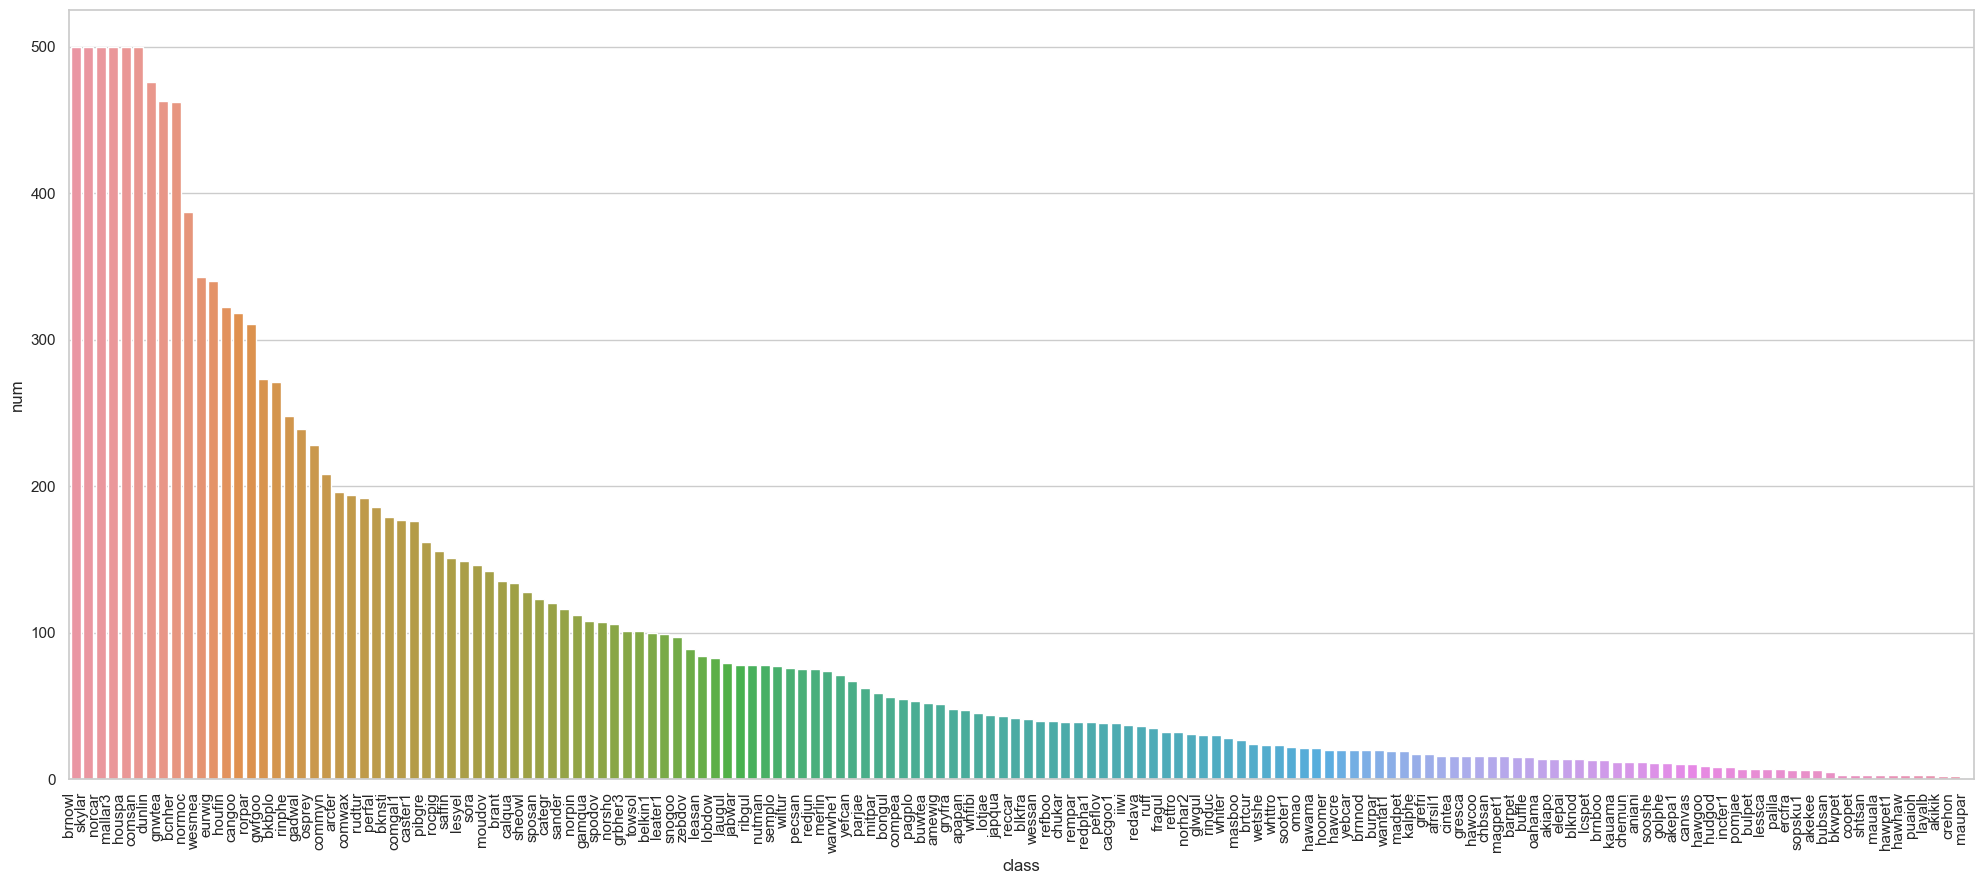

In [68]:
fig, ax = plt.subplots(figsize=(20,9))
ax = sb.barplot(data=df_orig.sort_values('num', ascending=False), x='class', y='num')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
plt.tight_layout()
plt.show()

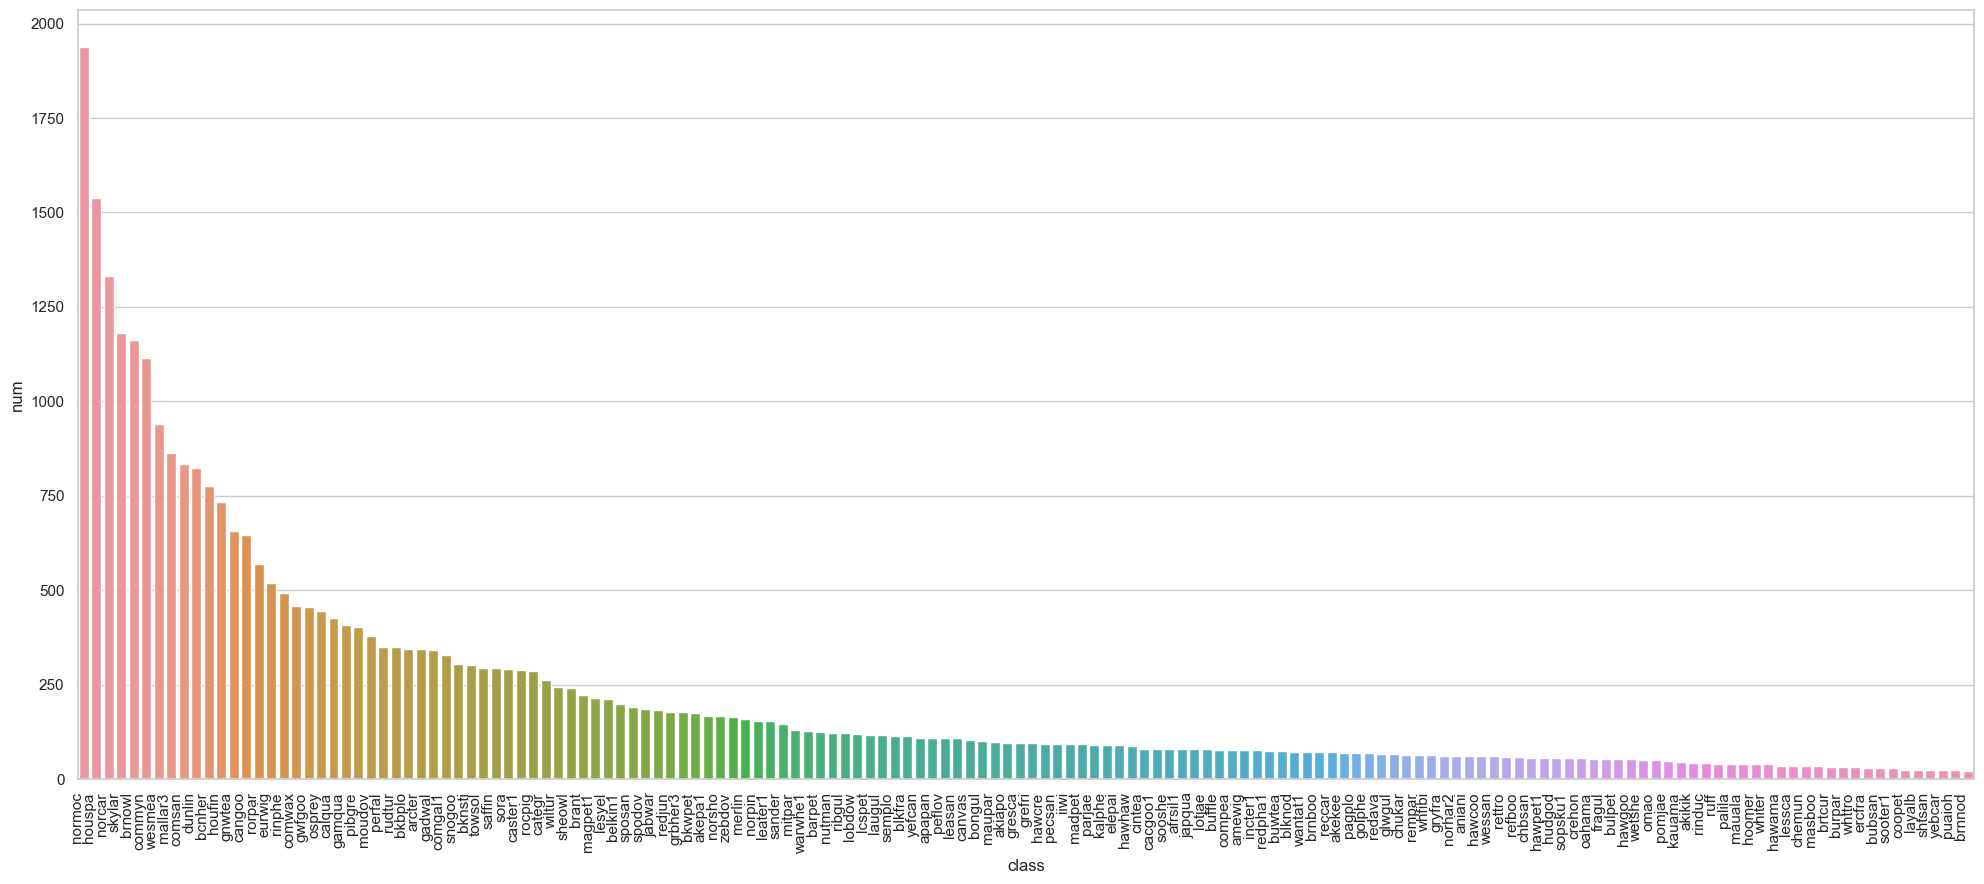

In [69]:
fig, ax = plt.subplots(figsize=(20,9))
plt.title("Original Class Distribution")
ax = sb.barplot(data=df.sort_values('num', ascending=False), x='class', y='num')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
plt.tight_layout()
plt.show()

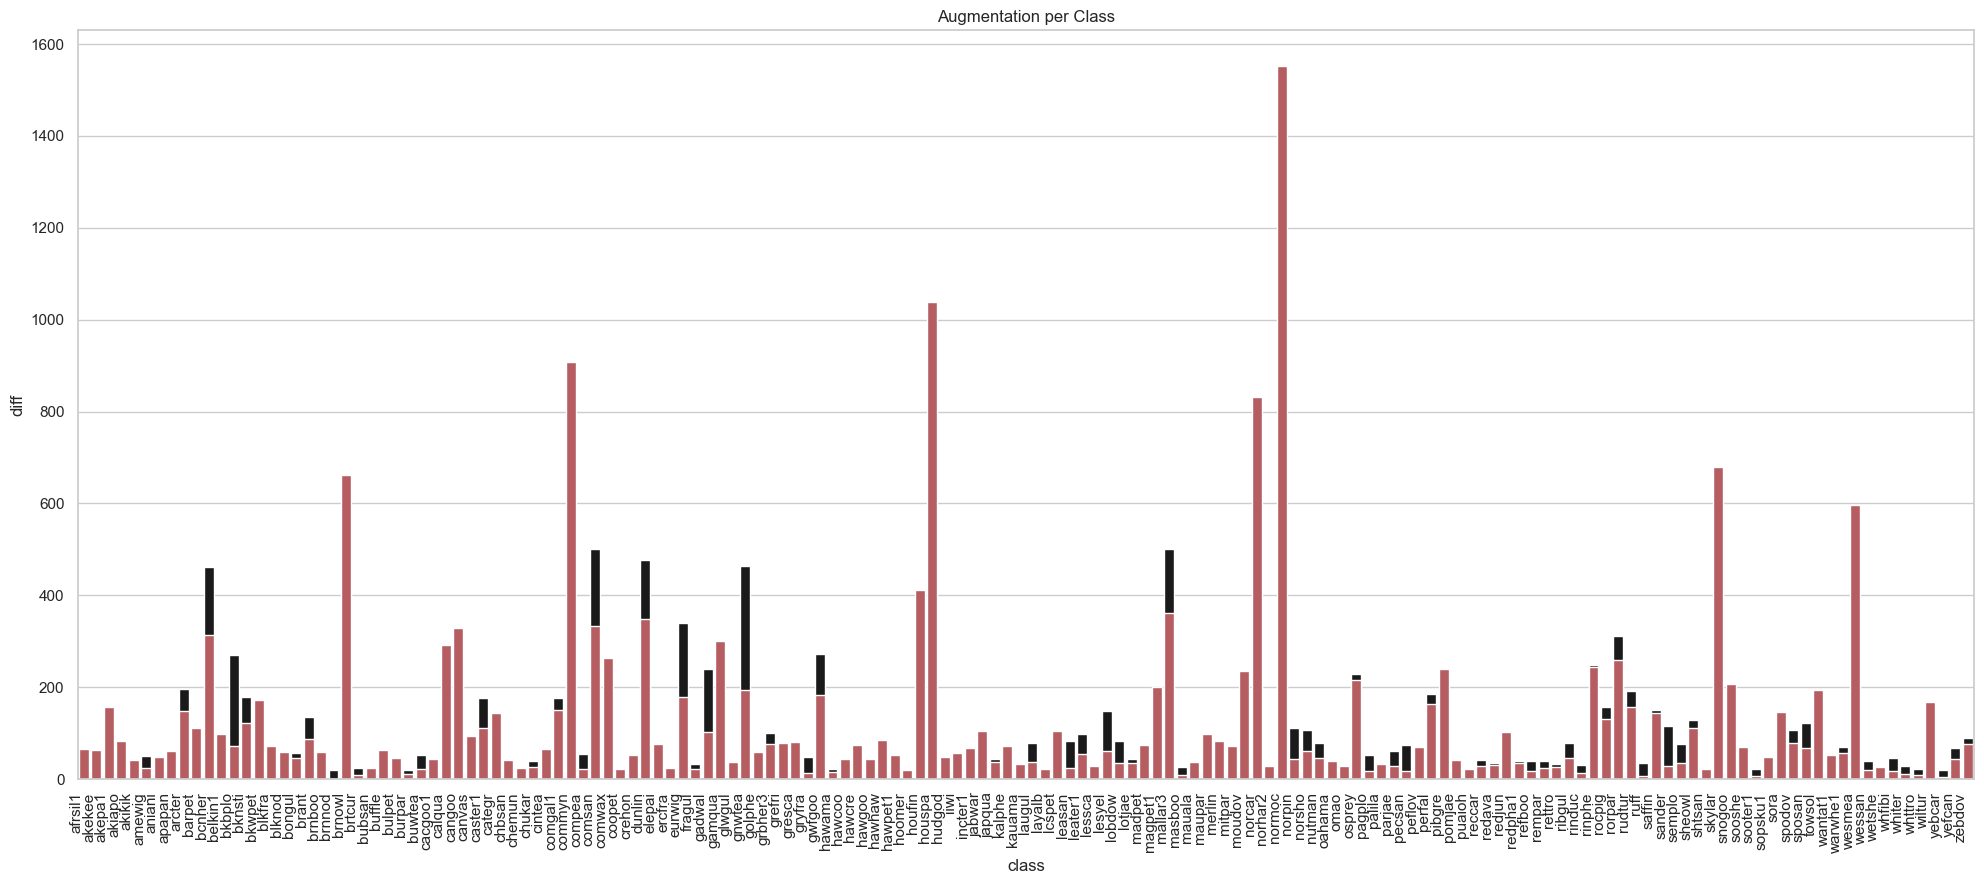

In [70]:
fig, ax = plt.subplots(figsize=(20,9))
plt.title("Augmentation per Class")
ax = sb.barplot(data=df_orig, x='class', y='num', color='k')
ax = sb.barplot(data=df_diff, x='class', y='diff', color='r')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
plt.tight_layout()
plt.show()

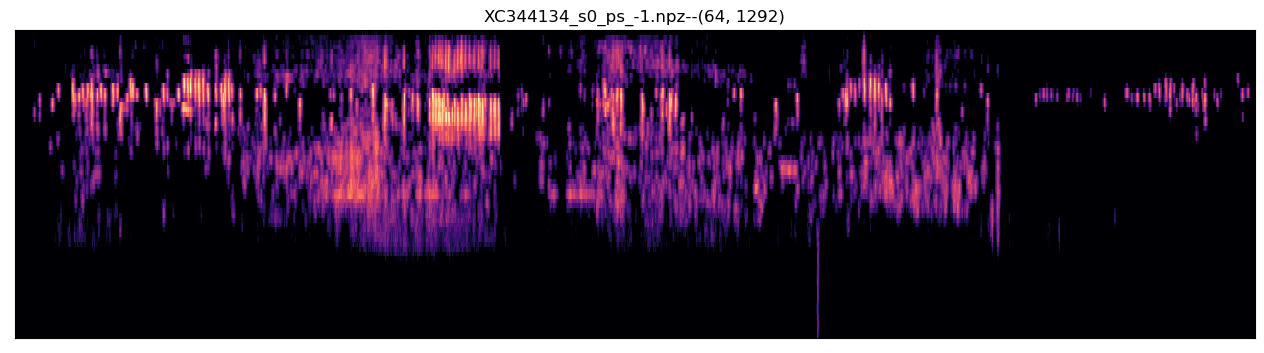

In [19]:
test = random.choice(os.listdir('../datasets/numpy_mel/data/afrsil1/'))
mel = np.load(f'../datasets/numpy_mel/data/afrsil1/{test}')
mel = mel['mel']

# show the spec
plt.figure(figsize=(16,4))
librosa.display.specshow(mel, sr=1024)
plt.title(f'{test}--{mel.shape}')
plt.show()
Audio(filename=f"../datasets/birdclef22/train_audio/afrsil1/{test.split('_')[0]}.ogg", rate=22_050)

In [6]:
sr = 20_000

In [10]:
import torchaudio

In [22]:
# librosa vs npy loading
test_samples = df.sample(100)['filename']
total_samples = 0
start = time.time()
for t in tqdm(test_samples):
    file = os.path.join('../datasets/birdclef22/train_audio/', t)
    #y = torchaudio.load(file)[0].numpy()
    #shift = librosa.effects.pitch_shift(y, sr=sr, n_steps=2, res_type='kaiser_fast')
    y, sr = librosa.load(file, sr=None, res_type='kaiser_fast', duration=None)
    samps = len(y)
    total_samples += samps
stop = time.time()

100%|██████████| 100/100 [00:07<00:00, 13.38it/s]


In [23]:
dataset_length = len(df)
total = stop-start
avg = total / 100
avg_per_time = total_samples / 100
print("total time", total)
print("average time", avg)
print("samples total", avg_per_time)
print("time to load ds", dataset_length*avg)

total time 7.47870397567749
average time 0.0747870397567749
samples total 1501842.33
time to load ds 1110.7371144676208


Kaiser fast
-----------------
    total time 35.63866972923279
    average time 0.35638669729232786
    samples total 912355.55
    time to load ds 5293.0552281856535

Kaiser best
-----------------
    total time 80.84255528450012
    average time 0.8084255528450012
    samples total 943532.88
    time to load ds 12006.736310853958

Kaiser fast 30s
-----------------
    total time 16.148550510406494
    average time 0.16148550510406495
    samples total 413094.96
    time to load ds 2398.3827218055726

Loading times:
kaiser_best : 

In [7]:
sample = random.choice(samples)
sample_reduced = nr.reduce_noise(sample, sr=sr)
shift = librosa.effects.pitch_shift(sample, sr=sr, n_steps=1, res_type='kaiser_fast')

In [8]:
Audio(shift, rate=sr)

In [9]:
Audio(sample, rate=sr)

In [10]:
Audio(sample_reduced, rate=sr)

In [11]:
os.remove('test.npy')
os.remove('test.ogg')

In [14]:
np.savez_compressed('test.npz', sample)

In [13]:
soundfile.write('test.ogg', sample, sr, format='ogg')